In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sbn
from sklearn.metrics import mean_absolute_error
from sklearn.externals import joblib
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline
import eli5
import matplotlib.pyplot as plt
from yellowbrick import regressor

from machine_learning.ml_data import MLData
from machine_learning import api
from machine_learning.settings import BASE_DIR

In [2]:
def predicted_home_margins(df, pred_col):
    home_teams = df.query('at_home == 1').sort_index()
    away_teams = (
        df
        .query('at_home == 0')
        .set_index(['oppo_team', 'year', 'round_number'])
        .rename_axis([None, None, None])
        .sort_index()
    )
    
    home_margin_multiplier = (
        (home_teams[pred_col] > away_teams[pred_col])
        .map(lambda x: 1 if x else -1)
    )
    
    return pd.Series(
        ((home_teams[pred_col].abs() + away_teams[pred_col].abs()) / 2) *
        home_margin_multiplier
    ).reindex(home_teams.index).sort_index()

def calculate_correct(y, y_pred):
    return (
        (y == 0) | ((y >= 0) & (y_pred >= 0)) | ((y <= 0) & (y_pred <= 0))
    )

## I. Get data

In [3]:
data = MLData(train_years=(None, 2018), test_years=(2019, 2019), end_date='2019-12-31')
data.data

2019-10-29 23:53:14,916 - kedro.io.data_catalog - INFO - Loading data from `roster_data` (JSONRemoteDataSet)...
Fetching roster data for round None...
Roster data received!
2019-10-29 23:53:23,142 - kedro.pipeline.node - INFO - Running node: convert_to_data_frame([roster_data]) -> [roster_data_frame]
2019-10-29 23:53:23,337 - kedro.io.data_catalog - INFO - Saving data to `roster_data_frame` (MemoryDataSet)...
2019-10-29 23:53:23,353 - kedro.runner.sequential_runner - INFO - Completed 1 out of 53 tasks
2019-10-29 23:53:23,358 - kedro.io.data_catalog - INFO - Loading data from `betting_data` (JSONLocalDataSet)...
2019-10-29 23:53:23,511 - kedro.io.data_catalog - INFO - Loading data from `remote_betting_data` (JSONRemoteDataSet)...
Fetching betting odds data from between 2019-01-01 and 2019-12-31...
Betting odds data received!
2019-10-29 23:53:40,771 - kedro.pipeline.node - INFO - Running node: convert_to_data_frame([betting_data,remote_betting_data]) -> [betting_data_frame,remote_betting

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


2019-10-29 23:57:49,018 - kedro.io.data_catalog - INFO - Saving data to `clean_betting_data` (MemoryDataSet)...
2019-10-29 23:57:49,024 - kedro.runner.sequential_runner - INFO - Completed 11 out of 53 tasks
2019-10-29 23:57:49,029 - kedro.io.data_catalog - INFO - Loading data from `combined_past_player_data` (MemoryDataSet)...
2019-10-29 23:57:49,140 - kedro.io.data_catalog - INFO - Loading data from `combined_past_match_data` (MemoryDataSet)...
2019-10-29 23:57:49,147 - kedro.pipeline.node - INFO - Running node: clean_player_data([combined_past_match_data,combined_past_player_data]) -> [clean_player_data]
2019-10-29 23:58:52,056 - kedro.io.data_catalog - INFO - Saving data to `clean_player_data` (MemoryDataSet)...
2019-10-29 23:58:52,381 - kedro.runner.sequential_runner - INFO - Completed 12 out of 53 tasks
2019-10-29 23:58:52,384 - kedro.io.data_catalog - INFO - Loading data from `clean_past_match_data` (MemoryDataSet)...
2019-10-29 23:58:52,391 - kedro.io.data_catalog - INFO - Loadi

2019-10-29 23:59:02,807 - kedro.pipeline.node - INFO - Running node: add_travel_distance([match_data_c]) -> [match_data_d]
2019-10-29 23:59:02,939 - kedro.io.data_catalog - INFO - Saving data to `match_data_d` (MemoryDataSet)...
2019-10-29 23:59:02,953 - kedro.runner.sequential_runner - INFO - Completed 28 out of 53 tasks
2019-10-29 23:59:02,955 - kedro.io.data_catalog - INFO - Loading data from `betting_data_c` (MemoryDataSet)...
2019-10-29 23:59:02,959 - kedro.pipeline.node - INFO - Running node: finalize_data([betting_data_c]) -> [final_betting_data]
2019-10-29 23:59:02,985 - kedro.io.data_catalog - INFO - Saving data to `final_betting_data` (MemoryDataSet)...
2019-10-29 23:59:02,989 - kedro.runner.sequential_runner - INFO - Completed 29 out of 53 tasks
2019-10-29 23:59:02,993 - kedro.io.data_catalog - INFO - Loading data from `player_data_a` (MemoryDataSet)...
2019-10-29 23:59:03,034 - kedro.pipeline.node - INFO - Running node: add_rolling_player_stats([player_data_a]) -> [player_d

/usr/local/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:983: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


2019-10-29 23:59:53,552 - kedro.io.data_catalog - INFO - Saving data to `player_data_b` (MemoryDataSet)...
2019-10-29 23:59:53,727 - kedro.runner.sequential_runner - INFO - Completed 30 out of 53 tasks
2019-10-29 23:59:53,730 - kedro.io.data_catalog - INFO - Loading data from `player_data_b` (MemoryDataSet)...
2019-10-29 23:59:53,790 - kedro.pipeline.node - INFO - Running node: add_cum_matches_played([player_data_b]) -> [player_data_c]
2019-10-29 23:59:53,991 - kedro.io.data_catalog - INFO - Saving data to `player_data_c` (MemoryDataSet)...
2019-10-29 23:59:54,175 - kedro.runner.sequential_runner - INFO - Completed 31 out of 53 tasks
2019-10-29 23:59:54,178 - kedro.io.data_catalog - INFO - Loading data from `match_data_d` (MemoryDataSet)...
2019-10-29 23:59:54,187 - kedro.pipeline.node - INFO - Running node: add_result([match_data_d]) -> [match_data_e]
2019-10-29 23:59:54,199 - kedro.io.data_catalog - INFO - Saving data to `match_data_e` (MemoryDataSet)...
2019-10-29 23:59:54,213 - ked

2019-10-30 00:02:30,398 - kedro.io.data_catalog - INFO - Saving data to `final_match_data` (MemoryDataSet)...
2019-10-30 00:02:30,414 - kedro.runner.sequential_runner - INFO - Completed 49 out of 53 tasks
2019-10-30 00:02:30,416 - kedro.io.data_catalog - INFO - Loading data from `final_betting_data` (MemoryDataSet)...
2019-10-30 00:02:30,421 - kedro.io.data_catalog - INFO - Loading data from `final_match_data` (MemoryDataSet)...
2019-10-30 00:02:30,432 - kedro.io.data_catalog - INFO - Loading data from `final_player_data` (MemoryDataSet)...
2019-10-30 00:02:30,439 - kedro.pipeline.node - INFO - Running node: _combine_data_horizontally([final_betting_data,final_match_data,final_player_data]) -> [joined_data]
2019-10-30 00:02:31,225 - kedro.io.data_catalog - INFO - Saving data to `joined_data` (MemoryDataSet)...
2019-10-30 00:02:31,253 - kedro.runner.sequential_runner - INFO - Completed 50 out of 53 tasks
2019-10-30 00:02:31,255 - kedro.io.data_catalog - INFO - Loading data from `joined_

team   oppo_team round_type  \
Adelaide         1991 1.0           Adelaide    Hawthorn    Regular   
                      2.0           Adelaide     Carlton    Regular   
                      3.0           Adelaide      Sydney    Regular   
                      4.0           Adelaide    Essendon    Regular   
                      5.0           Adelaide  West Coast    Regular   
...                                      ...         ...        ...   
Western Bulldogs 2019 20.0  Western Bulldogs    Brisbane    Regular   
                      21.0  Western Bulldogs    Essendon    Regular   
                      22.0  Western Bulldogs         GWS    Regular   
                      23.0  Western Bulldogs    Adelaide    Regular   
                      24.0  Western Bulldogs         GWS     Finals   

                                        venue  win_odds  line_odds  \
Adelaide         1991 1.0       Football Park      0.00        0.0   
                      2.0       Football Park      0.00        0.0   
                      3.0              S.C.G.      0.00        0.0   
                      4.0          Windy Hill      0.00        0.0   
                      5.0             Subiaco      0.00        0.0   
...                                       ...       ...        ...   
Western Bulldogs 2019 20.0              Gabba      3.15       18.5   
                      21.0          Docklands      1.68       -6.5   
                      22.0  Sydney Showground      2.15        5.5   
                      23.0     Eureka Stadium      1.33      -18.5   
                      24.0  Sydney Showground      2.00        2.5   

                            oppo_win_odds  oppo_line_odds  betting_pred_win  \
Adelaide         1991 1.0            0.00             0.0               0.0   
                      2.0            0.00             0.0               0.0   
                      3.0            0.00             0.0               0.0   
                      4.0            0.00             0.0               0.0   
                      5.0            0.00             0.0               0.0   
...                                   ...             ...               ...   
Western Bulldogs 2019 20.0           1.36           -18.5               0.0   
                      21.0           2.20             6.5               1.0   
                      22.0           1.71            -5.5               0.0   
                      23.0           3.35            18.5               1.0   
                      24.0           1.82            -2.5               0.0   

                            rolling_betting_pred_win_rate  ...  \
Adelaide         1991 1.0                        0.000000  ...   
                      2.0                        0.000000  ...   
                      3.0                        0.000000  ...   
                      4.0                        0.000000  ...   
                      5.0                        0.000000  ...   
...                                                   ...  ...   
Western Bulldogs 2019 20.0                       0.391304  ...   
                      21.0                       0.434783  ...   
                      22.0                       0.434783  ...   
                      23.0                       0.434783  ...   
                      24.0                       0.434783  ...   

                            oppo_rolling_mean_score_by_venue  cum_percent  \
Adelaide         1991 1.0                              0.000     0.000000   
                      2.0                              0.000     2.246377   
                      3.0                             91.000     1.364162   
                      4.0                            114.625     1.309609   
                      5.0                            118.125     1.112601   
...                                                      ...          ...   
Western Bulldogs 2019 20.0                            93.125     

In [4]:
df = data.data.query('round_number != 0')
df

team   oppo_team round_type  \
Adelaide         1991 1.0           Adelaide    Hawthorn    Regular   
                      2.0           Adelaide     Carlton    Regular   
                      3.0           Adelaide      Sydney    Regular   
                      4.0           Adelaide    Essendon    Regular   
                      5.0           Adelaide  West Coast    Regular   
...                                      ...         ...        ...   
Western Bulldogs 2019 20.0  Western Bulldogs    Brisbane    Regular   
                      21.0  Western Bulldogs    Essendon    Regular   
                      22.0  Western Bulldogs         GWS    Regular   
                      23.0  Western Bulldogs    Adelaide    Regular   
                      24.0  Western Bulldogs         GWS     Finals   

                                        venue  win_odds  line_odds  \
Adelaide         1991 1.0       Football Park      0.00        0.0   
                      2.0       Football Park      0.00        0.0   
                      3.0              S.C.G.      0.00        0.0   
                      4.0          Windy Hill      0.00        0.0   
                      5.0             Subiaco      0.00        0.0   
...                                       ...       ...        ...   
Western Bulldogs 2019 20.0              Gabba      3.15       18.5   
                      21.0          Docklands      1.68       -6.5   
                      22.0  Sydney Showground      2.15        5.5   
                      23.0     Eureka Stadium      1.33      -18.5   
                      24.0  Sydney Showground      2.00        2.5   

                            oppo_win_odds  oppo_line_odds  betting_pred_win  \
Adelaide         1991 1.0            0.00             0.0               0.0   
                      2.0            0.00             0.0               0.0   
                      3.0            0.00             0.0               0.0   
                      4.0            0.00             0.0               0.0   
                      5.0            0.00             0.0               0.0   
...                                   ...             ...               ...   
Western Bulldogs 2019 20.0           1.36           -18.5               0.0   
                      21.0           2.20             6.5               1.0   
                      22.0           1.71            -5.5               0.0   
                      23.0           3.35            18.5               1.0   
                      24.0           1.82            -2.5               0.0   

                            rolling_betting_pred_win_rate  ...  \
Adelaide         1991 1.0                        0.000000  ...   
                      2.0                        0.000000  ...   
                      3.0                        0.000000  ...   
                      4.0                        0.000000  ...   
                      5.0                        0.000000  ...   
...                                                   ...  ...   
Western Bulldogs 2019 20.0                       0.391304  ...   
                      21.0                       0.434783  ...   
                      22.0                       0.434783  ...   
                      23.0                       0.434783  ...   
                      24.0                       0.434783  ...   

                            oppo_rolling_mean_score_by_venue  cum_percent  \
Adelaide         1991 1.0                              0.000     0.000000   
                      2.0                              0.000     2.246377   
                      3.0                             91.000     1.364162   
                      4.0                            114.625     1.309609   
                      5.0                            118.125     1.112601   
...                                                      ...          ...   
Western Bulldogs 2019 20.0                            93.125     

In [5]:
preds = api.make_predictions(year_range=(2019, 2020), ml_model_names=['tipresias'])
preds_df = pd.DataFrame(preds.get('data'))
preds_df

Making predictions with tipresias
2019-10-30 00:02:32,525 - kedro.io.data_catalog - INFO - Loading data from `roster_data` (JSONRemoteDataSet)...


/usr/local/lib/python3.6/site-packages/pandas/core/indexes/base.py:183: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


Fetching roster data for round None...
Roster data received!
2019-10-30 00:02:34,144 - kedro.pipeline.node - INFO - Running node: convert_to_data_frame([roster_data]) -> [roster_data_frame]
2019-10-30 00:02:34,161 - kedro.io.data_catalog - INFO - Saving data to `roster_data_frame` (MemoryDataSet)...
2019-10-30 00:02:34,165 - kedro.runner.sequential_runner - INFO - Completed 1 out of 53 tasks
2019-10-30 00:02:34,169 - kedro.io.data_catalog - INFO - Loading data from `betting_data` (JSONLocalDataSet)...
2019-10-30 00:02:34,201 - kedro.io.data_catalog - INFO - Loading data from `remote_betting_data` (JSONRemoteDataSet)...
Fetching betting odds data from between 2019-01-01 and 2019-12-31...
Betting odds data received!
2019-10-30 00:02:40,931 - kedro.pipeline.node - INFO - Running node: convert_to_data_frame([betting_data,remote_betting_data]) -> [betting_data_frame,remote_betting_data_frame]
2019-10-30 00:02:40,953 - kedro.io.data_catalog - INFO - Saving data to `betting_data_frame` (Memor

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


2019-10-30 00:06:01,962 - kedro.io.data_catalog - INFO - Saving data to `clean_betting_data` (MemoryDataSet)...
2019-10-30 00:06:01,983 - kedro.runner.sequential_runner - INFO - Completed 11 out of 53 tasks
2019-10-30 00:06:01,990 - kedro.io.data_catalog - INFO - Loading data from `combined_past_player_data` (MemoryDataSet)...
2019-10-30 00:06:02,618 - kedro.io.data_catalog - INFO - Loading data from `combined_past_match_data` (MemoryDataSet)...
2019-10-30 00:06:02,637 - kedro.pipeline.node - INFO - Running node: clean_player_data([combined_past_match_data,combined_past_player_data]) -> [clean_player_data]
2019-10-30 00:07:23,140 - kedro.io.data_catalog - INFO - Saving data to `clean_player_data` (MemoryDataSet)...
2019-10-30 00:07:23,604 - kedro.runner.sequential_runner - INFO - Completed 12 out of 53 tasks
2019-10-30 00:07:23,609 - kedro.io.data_catalog - INFO - Loading data from `clean_past_match_data` (MemoryDataSet)...
2019-10-30 00:07:23,629 - kedro.io.data_catalog - INFO - Loadi

2019-10-30 00:07:34,310 - kedro.pipeline.node - INFO - Running node: add_travel_distance([match_data_c]) -> [match_data_d]
2019-10-30 00:07:34,346 - kedro.io.data_catalog - INFO - Saving data to `match_data_d` (MemoryDataSet)...
2019-10-30 00:07:34,355 - kedro.runner.sequential_runner - INFO - Completed 28 out of 53 tasks
2019-10-30 00:07:34,358 - kedro.io.data_catalog - INFO - Loading data from `betting_data_c` (MemoryDataSet)...
2019-10-30 00:07:34,365 - kedro.pipeline.node - INFO - Running node: finalize_data([betting_data_c]) -> [final_betting_data]
2019-10-30 00:07:34,401 - kedro.io.data_catalog - INFO - Saving data to `final_betting_data` (MemoryDataSet)...
2019-10-30 00:07:34,406 - kedro.runner.sequential_runner - INFO - Completed 29 out of 53 tasks
2019-10-30 00:07:34,413 - kedro.io.data_catalog - INFO - Loading data from `player_data_a` (MemoryDataSet)...
2019-10-30 00:07:34,433 - kedro.pipeline.node - INFO - Running node: add_rolling_player_stats([player_data_a]) -> [player_d

/usr/local/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:983: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


2019-10-30 00:07:48,914 - kedro.io.data_catalog - INFO - Saving data to `player_data_b` (MemoryDataSet)...
2019-10-30 00:07:48,970 - kedro.runner.sequential_runner - INFO - Completed 30 out of 53 tasks
2019-10-30 00:07:48,972 - kedro.io.data_catalog - INFO - Loading data from `player_data_b` (MemoryDataSet)...
2019-10-30 00:07:49,003 - kedro.pipeline.node - INFO - Running node: add_cum_matches_played([player_data_b]) -> [player_data_c]
2019-10-30 00:07:49,099 - kedro.io.data_catalog - INFO - Saving data to `player_data_c` (MemoryDataSet)...
2019-10-30 00:07:49,151 - kedro.runner.sequential_runner - INFO - Completed 31 out of 53 tasks
2019-10-30 00:07:49,156 - kedro.io.data_catalog - INFO - Loading data from `match_data_d` (MemoryDataSet)...
2019-10-30 00:07:49,162 - kedro.pipeline.node - INFO - Running node: add_result([match_data_d]) -> [match_data_e]
2019-10-30 00:07:49,180 - kedro.io.data_catalog - INFO - Saving data to `match_data_e` (MemoryDataSet)...
2019-10-30 00:07:49,188 - ked

2019-10-30 00:08:50,387 - kedro.io.data_catalog - INFO - Saving data to `final_match_data` (MemoryDataSet)...
2019-10-30 00:08:50,403 - kedro.runner.sequential_runner - INFO - Completed 49 out of 53 tasks
2019-10-30 00:08:50,412 - kedro.io.data_catalog - INFO - Loading data from `final_betting_data` (MemoryDataSet)...
2019-10-30 00:08:50,418 - kedro.io.data_catalog - INFO - Loading data from `final_match_data` (MemoryDataSet)...
2019-10-30 00:08:50,433 - kedro.io.data_catalog - INFO - Loading data from `final_player_data` (MemoryDataSet)...
2019-10-30 00:08:50,442 - kedro.pipeline.node - INFO - Running node: _combine_data_horizontally([final_betting_data,final_match_data,final_player_data]) -> [joined_data]
2019-10-30 00:08:50,666 - kedro.io.data_catalog - INFO - Saving data to `joined_data` (MemoryDataSet)...
2019-10-30 00:08:50,685 - kedro.runner.sequential_runner - INFO - Completed 50 out of 53 tasks
2019-10-30 00:08:50,687 - kedro.io.data_catalog - INFO - Loading data from `joined_

,team,year,round_number,oppo_team,at_home,ml_model,predicted_margin
0,Adelaide,2019.0,1.0,Hawthorn,1.0,tipresias,7.570836
1,Adelaide,2019.0,2.0,Sydney,0.0,tipresias,3.304739
2,Adelaide,2019.0,3.0,Geelong,1.0,tipresias,-0.452266
3,Adelaide,2019.0,4.0,North Melbourne,0.0,tipresias,5.749722
4,Adelaide,2019.0,5.0,Gold Coast,1.0,tipresias,37.105408
...,...,...,...,...,...,...,...
411,Western Bulldogs,2019.0,20.0,Brisbane,0.0,tipresias,-13.569069
412,Western Bulldogs,2019.0,21.0,Essendon,0.0,tipresias,0.540407
413,Western Bulldogs,2019.0,22.0,GWS,0.0,tipresias,-2.196697
414,Western Bulldogs,2019.0,23.0,Adelaide,1.0,tipresias,16.480190


In [6]:
preds_to_concat = (
    preds_df
    .query('team != 0')
    .set_index(['team', 'year', 'round_number'])
    .loc[:, 'predicted_margin']
    .rename_axis([None] * 3)
)

combined_df = pd.concat([df, preds_to_concat], axis=1, join='inner')
combined_df

,,,team,oppo_team,round_type,venue,win_odds,line_odds,oppo_win_odds,oppo_line_odds,betting_pred_win,rolling_betting_pred_win_rate,...,cum_percent,ladder_position,elo_pred_win,rolling_elo_pred_win_rate,elo_rating_divided_by_ladder_position,oppo_cum_percent,oppo_ladder_position,elo_rating_divided_by_win_odds,win_odds_multiplied_by_ladder_position,predicted_margin
St Kilda,2019.0,21.0,St Kilda,Fremantle,Regular,Docklands,1.50,-13.5,2.60,13.5,1.0,0.217391,...,0.842481,14.0,0.0,0.173913,68.637432,0.954098,12.0,640.616028,21.00,21.271803
GWS,2019.0,11.0,GWS,Gold Coast,Regular,Sydney Showground,1.04,-52.5,12.00,52.5,1.0,0.739130,...,1.261519,4.0,1.0,0.652174,249.572723,0.683663,17.0,959.895090,4.16,54.594494
Richmond,2019.0,1.0,Richmond,Carlton,Regular,M.C.G.,1.12,-39.5,6.75,39.5,1.0,0.891304,...,0.597938,14.0,1.0,1.000000,71.322196,0.369697,17.0,891.527446,15.68,28.404566
Sydney,2019.0,20.0,Sydney,GWS,Regular,Sydney Showground,3.50,21.5,1.30,-21.5,0.0,0.260870,...,0.909980,15.0,0.0,0.434783,65.164915,1.208483,6.0,279.278206,52.50,-9.024456
Western Bulldogs,2019.0,23.0,Western Bulldogs,Adelaide,Regular,Eureka Stadium,1.33,-18.5,3.35,18.5,1.0,0.434783,...,1.051620,9.0,1.0,0.347826,110.008570,1.089947,8.0,744.418896,11.97,16.480190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Collingwood,2019.0,16.0,Collingwood,Hawthorn,Regular,M.C.G.,1.45,-14.5,2.75,14.5,1.0,0.869565,...,1.180164,3.0,1.0,0.826087,330.338735,0.944719,15.0,683.459451,4.35,5.703149
Adelaide,2019.0,13.0,Adelaide,Richmond,Regular,Adelaide Oval,1.18,-32.5,5.15,32.5,1.0,0.652174,...,1.228602,2.0,1.0,0.521739,495.930130,0.914077,3.0,840.559542,2.36,22.318569
Brisbane,2019.0,24.0,Brisbane,Richmond,Finals,Gabba,2.15,5.5,1.71,-5.5,0.0,0.478261,...,1.158482,2.0,0.0,0.608696,496.236064,1.107325,4.0,461.614943,4.30,35.203960
Fremantle,2019.0,23.0,Fremantle,Port Adelaide,Regular,Adelaide Oval,3.35,20.5,1.33,-20.5,0.0,0.391304,...,0.937648,13.0,0.0,0.260870,74.029100,1.015358,11.0,287.277105,43.55,-25.459442


## II. Model Performance vs Betting Odds

In [7]:
home_data = combined_df.query('at_home == 1').sort_index()

# Using oppo_line_odds, because -line_odds roughly equals predicted margin
betting_match_preds = predicted_home_margins(combined_df, 'oppo_line_odds')
betting_correct = calculate_correct(home_data['margin'], betting_match_preds)
betting_points = betting_correct.sum()
betting_acc = betting_correct.mean()
betting_mae = mean_absolute_error(home_data['margin'], betting_match_preds)

model_match_preds = predicted_home_margins(combined_df, 'predicted_margin')
model_correct = calculate_correct(home_data['margin'], model_match_preds)
model_points = model_correct.sum()
model_acc = model_correct.mean()
model_mae = mean_absolute_error(home_data['margin'], model_match_preds)

print('2019 Tipping Points')
print('Betting Odds:', betting_points)
print('Tipresias:', model_points)

print('\n2019 Accuracy')
print('Betting Odds:', betting_acc)
print('Tipresias:', model_acc)

print('\n2019 MAE')
print('Betting Odds:', betting_mae)
print('Tipresias:', model_mae)

2019 Tipping Points
Betting Odds: 140
Tipresias: 137

2019 Accuracy
Betting Odds: 0.6763285024154589
Tipresias: 0.6618357487922706

2019 MAE
Betting Odds: 26.2512077294686
Tipresias: 26.77038138292298


### Subpar performance relative to betting odds across all metrics

After beating the odds by one point last season, and being slightly better on the test set while developing the model, Tipresias was a full 3 points short in 2019. All models (including betting odds) performed below-average this season, however, due to an unusual number of upsets, especially early in the year, resulting in less difference between good and bad teams than in most seasons.

In [8]:
per_round_acc = (
    pd
    .concat([betting_correct, model_correct], axis=1)
    .rename(columns={0: 'betting', 1: 'tipresias'})
    .reset_index()
    .drop(['level_0', 'level_1'], axis=1)
    .rename(columns={'level_2': 'round_number'})
    .groupby('round_number')
    .mean()
)

per_round_acc

,betting,tipresias
round_number,,
1.0,0.333333,0.333333
2.0,0.555556,0.555556
3.0,0.777778,0.666667
4.0,0.444444,0.444444
5.0,0.555556,0.444444
6.0,0.888889,0.888889
7.0,0.777778,0.777778
8.0,0.666667,0.666667
9.0,0.888889,0.888889


2019-10-30 00:08:53,038 - matplotlib.font_manager - WARNING - findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
2019-10-30 00:08:53,105 - matplotlib.font_manager - WARNING - findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


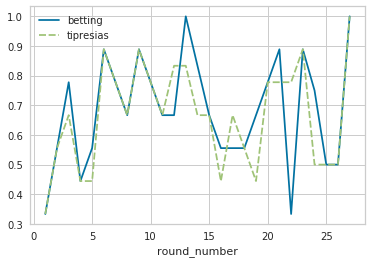

In [9]:
sbn.lineplot(data=per_round_acc)

2019-10-30 00:08:53,771 - matplotlib.font_manager - WARNING - findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
2019-10-30 00:08:53,783 - matplotlib.font_manager - WARNING - findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
2019-10-30 00:08:53,839 - matplotlib.font_manager - WARNING - findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


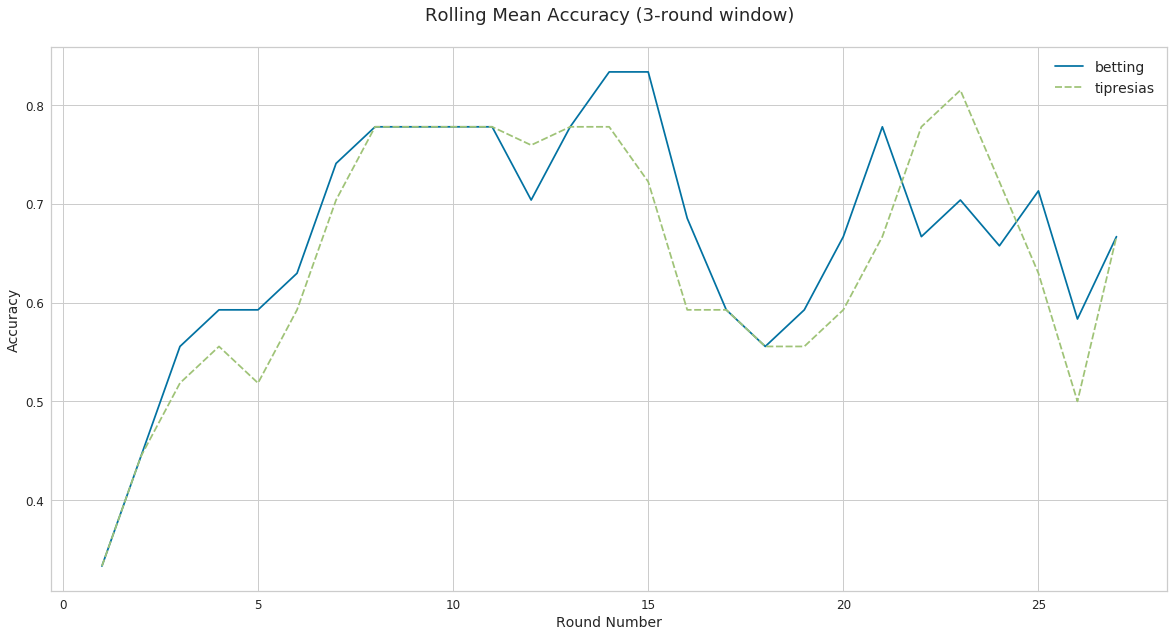

In [10]:
rolling_acc = per_round_acc.rolling(3).mean().fillna(per_round_acc.expanding(0).mean())

plt.figure(figsize=(20, 10))

sbn.lineplot(data=rolling_acc)

plt.title(
    "Rolling Mean Accuracy (3-round window)\n",
    fontsize=18
)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Round Number", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=14)

In [11]:
rolling_acc

,betting,tipresias
round_number,,
1.0,0.333333,0.333333
2.0,0.444444,0.444444
3.0,0.555556,0.518519
4.0,0.592593,0.555556
5.0,0.592593,0.518519
6.0,0.629630,0.592593
7.0,0.740741,0.703704
8.0,0.777778,0.777778
9.0,0.777778,0.777778


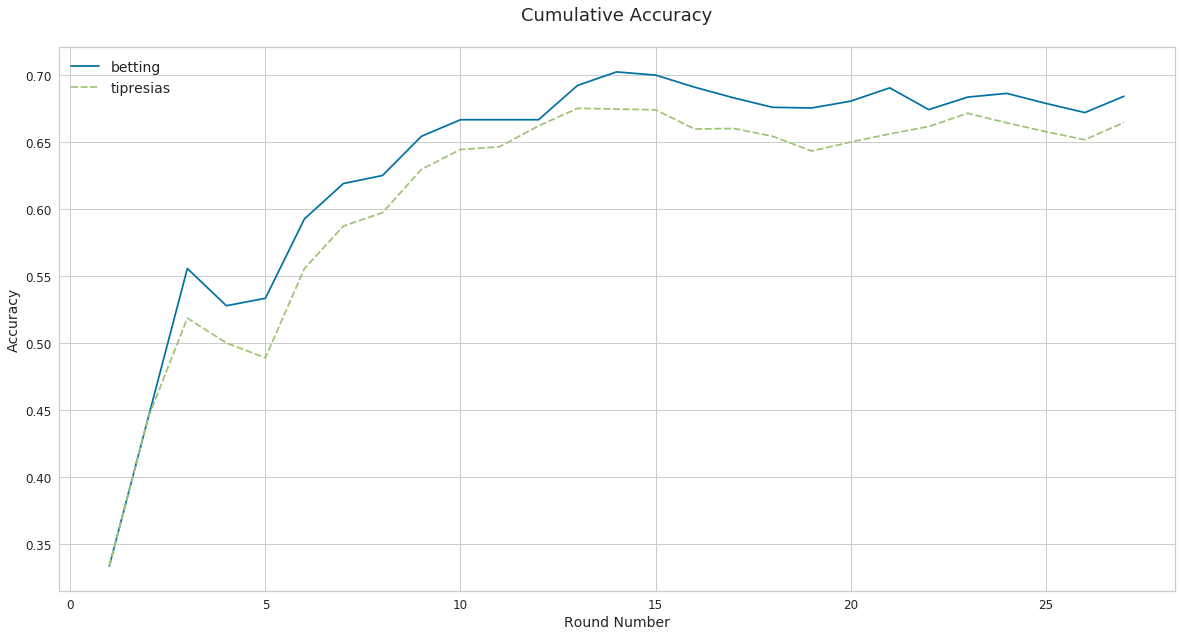

In [12]:
plt.figure(figsize=(20, 10))

sbn.lineplot(data=per_round_acc.expanding(0).mean())

plt.title(
    "Cumulative Accuracy\n",
    fontsize=18
)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Round Number", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=14)

### Tipresias slightly underperformed the betting odds across most of the season

There were periods where the two were roughly even, and Tipresias had a higher rolling accuracy for a bit late in the season (mostly due to an atrocious round 22 for the betting odds), but it was consistently slightly worse. The expanding mean shows this well, because at no point did Tipresias have a higher overall accuracy.

## III. Analyse model features

In [13]:
tipresias = joblib.load(
    os.path.join(
        BASE_DIR,
        'src/machine_learning/ml_estimators/bagging_estimator/tipresias.pkl'
    )
)

/usr/local/lib/python3.6/site-packages/pandas/core/indexes/base.py:183: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


In [14]:
from machine_learning.data_config import TEAM_NAMES, ROUND_TYPES, VENUES, CATEGORY_COLS

# Need to run numeric columns through the trained column selector to get the columns
# actually used by the model
selected_numeric_cols = list(
    tipresias
    .pipeline
    .steps[0][1]
    .transform(df)
    .drop(['team', 'oppo_team', 'round_type', 'venue'], axis=1)
    .columns
)

oppo_team_names = ['oppo_' + name for name in TEAM_NAMES]

transformed_features = (
    # Dropping last two venues, because they were added after training
    TEAM_NAMES + oppo_team_names + ROUND_TYPES + VENUES[:-2] + selected_numeric_cols
)
transformed_features

['Adelaide',
 'Brisbane',
 'Carlton',
 'Collingwood',
 'Essendon',
 'Fitzroy',
 'Fremantle',
 'GWS',
 'Geelong',
 'Gold Coast',
 'Hawthorn',
 'Melbourne',
 'North Melbourne',
 'Port Adelaide',
 'Richmond',
 'St Kilda',
 'Sydney',
 'University',
 'West Coast',
 'Western Bulldogs',
 'oppo_Adelaide',
 'oppo_Brisbane',
 'oppo_Carlton',
 'oppo_Collingwood',
 'oppo_Essendon',
 'oppo_Fitzroy',
 'oppo_Fremantle',
 'oppo_GWS',
 'oppo_Geelong',
 'oppo_Gold Coast',
 'oppo_Hawthorn',
 'oppo_Melbourne',
 'oppo_North Melbourne',
 'oppo_Port Adelaide',
 'oppo_Richmond',
 'oppo_St Kilda',
 'oppo_Sydney',
 'oppo_University',
 'oppo_West Coast',
 'oppo_Western Bulldogs',
 'Finals',
 'Regular',
 'Marrara Oval',
 'AAMI Stadium',
 'Moorabbin Oval',
 'Princes Park',
 'Stadium Australia',
 'Coburg Oval',
 'Junction Oval',
 'Lake Oval',
 'Jiangwan Stadium',
 'Manuka Oval',
 'Arden St',
 'ANZ Stadium',
 'Blacktown International',
 'Toorak Park',
 'Euroa',
 'Etihad Stadium',
 'Kardinia Park',
 'Adelaide Oval',


In [15]:
explained_gains = []

for idx, estimator in enumerate(tipresias.pipeline.steps[-1][1].estimators_):
    gain_df = eli5.explain_weights_df(
        estimator,
        feature_names=transformed_features,
        importance_type='gain',
    ).set_index('feature').rename(columns={'weight': f'weight_{idx}'})
    
    explained_gains.append(gain_df)

In [16]:
avg_gains = (
    pd
    .concat(explained_gains, axis=1, sort=False)
    .mean(axis=1)
    .sort_values(ascending=False)
    .rename('gains')
)
avg_gains.head(20)

elo_pred_win                              0.390352
at_home                                   0.049073
Regular                                   0.021233
Finals                                    0.014616
elo_rating_divided_by_win_odds            0.012382
oppo_elo_rating                           0.012057
elo_rating                                0.011189
rolling_prev_match_result_rate            0.009372
oppo_line_odds                            0.009128
win_odds_multiplied_by_ladder_position    0.008122
oppo_rolling_prev_match_result_rate       0.008103
oppo_rolling_mean_result_by_venue         0.007769
rolling_mean_result_by_venue              0.007171
oppo_win_odds                             0.007097
oppo_travel_distance                      0.007093
win_odds                                  0.006842
oppo_rolling_mean_margin_by_venue         0.006623
oppo_cum_percent                          0.006566
line_odds                                 0.006324
rolling_mean_margin_by_venue   

In [17]:
print("% team-matches for which Elo and Tipresias agree")
((combined_df['elo_pred_win'] == 1) & (combined_df['predicted_margin'] > 0)).mean()

% team-matches for which Elo and Tipresias agree


0.4057971014492754

In [18]:
print("Elo accuracy")
(
    ((combined_df['elo_pred_win'] == 1) & (combined_df['margin'] > 0)) |
    ((combined_df['elo_pred_win'] == 0) & (combined_df['margin'] < 0))
).mean()

Elo accuracy


0.6086956521739131

In [19]:
avg_gains.drop(avg_gains.filter(regex='elo').index.values).head(20)

at_home                                   0.049073
Regular                                   0.021233
Finals                                    0.014616
rolling_prev_match_result_rate            0.009372
oppo_line_odds                            0.009128
win_odds_multiplied_by_ladder_position    0.008122
oppo_rolling_prev_match_result_rate       0.008103
oppo_rolling_mean_result_by_venue         0.007769
rolling_mean_result_by_venue              0.007171
oppo_win_odds                             0.007097
oppo_travel_distance                      0.007093
win_odds                                  0.006842
oppo_rolling_mean_margin_by_venue         0.006623
oppo_cum_percent                          0.006566
line_odds                                 0.006324
rolling_mean_margin_by_venue              0.005812
travel_distance                           0.005766
cum_percent                               0.005652
oppo_last_year_brownlow_votes_sum         0.004724
oppo_rolling_prev_match_behinds

### Elo by far most important features, followed by home/away and round type

It would seem that including the Elo model as a simple set of features is making my model a glorified wrapper of said model. I read in Google's [guide to ML](https://developers.google.com/machine-learning/guides/rules-of-ml#ml_phase_iii_slowed_growth_optimization_refinement_and_complex_models) that it's best to separate model-output features from features derived from raw data (Rule #40), so I'll probably restructure the ensemble to be a few base models that feed predictions into a meta estimator.

It's interesting that the categorical variables `at_home` and `round_type` are the most important after Elo-based features. It might have to do with ELO already accounting for otherwise-important features like `win_odds` and `rolling_prev_match_result_rate` (i.e. rolling win rate), thus "stealing" their gain values. Although, home/away is accounted for in the Elo model, round type isn't, and that might explain the latters unusual importance. It stands to reason that a model should take regular season vs finals into account as the latter represents a very different context: every match is win or you're done, teams are more-evenly matched, players are more tired & hurt at the end of the season, there's much more psychological pressure, etc.

## IV Analyse early season predictions

In [20]:
X_test, y_test = data.test_data()
base_pipeline = make_pipeline(*[step[1] for step in tipresias.pipeline.steps[:-1]])
# Using round 5 as the cutoff for early rounds for no particular reason
trans_X_test = base_pipeline.transform(X_test.query('round_number <= 5'))

pred_gains = []

for ridx, row in enumerate(trans_X_test):
    for eidx, estimator in enumerate(tipresias.pipeline.steps[-1][1].estimators_):
        pred_gains.append(
            eli5.explain_prediction_df(
                estimator,
                row,
                feature_names=transformed_features,
            )
            .set_index('feature')
            .drop(['target', 'value'], axis=1)
            .rename(columns={'weight': f'weight_{eidx}_{ridx}'})
        )

In [23]:
trans_X_test = base_pipeline.transform(X_test)

round_groups = X_test.query('round_number != 0').groupby('round_number')
round_gains = []

for round_number, group_df in round_groups:
    for row in base_pipeline.transform(group_df):
        estimator = tipresias.pipeline.steps[-1][1].estimators_[0]
        round_gains.append(
            eli5.explain_prediction_df(
                estimator,
                row,
                feature_names=transformed_features,
            )
            .drop(['target', 'value'], axis=1)
            # Weights are relative to the output score of the estimator, which can be positive or negative,
            # so we normalize across estimators by getting the absolute value & dividing by the sum
            .assign(round_number=round_number, weight=lambda df: df['weight'].abs() / df['weight'].abs().sum())
        )
        
gains_by_round = (
    pd
    .concat(round_gains, axis=0, sort=False)
)

gains_by_round

,feature,weight,round_number
0,elo_rating_divided_by_win_odds,0.058514,1.0
1,at_home,0.052625,1.0
2,oppo_rolling_prev_match_behinds_sum,0.040936,1.0
3,oppo_cum_percent,0.036094,1.0
4,Adelaide,0.031767,1.0
...,...,...,...
98,oppo_rolling_prev_match_inside_50s_min,0.017577,27.0
99,oppo_cum_percent,0.019704,27.0
100,Richmond,0.025943,27.0
101,oppo_rolling_prev_match_result_rate,0.026918,27.0


In [24]:
avg_gains_by_round = (
    gains_by_round
    .groupby(['feature', 'round_number'], group_keys=True)
    .mean()
)

expanding_gains = (
    avg_gains_by_round
    .groupby('feature', group_keys=False)
    .expanding(0)
    .mean()
)
expanding_gains

weight
feature    round_number          
<BIAS>     1.0           0.009348
           2.0           0.008832
           3.0           0.008638
           4.0           0.008620
           5.0           0.008668
...                           ...
win_streak 23.0          0.007692
           24.0          0.007570
           25.0          0.007475
           26.0          0.007367
           27.0          0.007593

[3739 rows x 1 columns]

In [25]:
rolling_gains = (
    avg_gains_by_round
    .groupby('feature', group_keys=False)
    .rolling(window=3)
    .mean()
    .fillna(expanding_gains)
)
rolling_gains

weight
feature    round_number          
<BIAS>     1.0           0.009348
           2.0           0.008832
           3.0           0.008638
           4.0           0.008377
           5.0           0.008559
...                           ...
win_streak 23.0          0.007307
           24.0          0.006820
           25.0          0.005915
           26.0          0.004880
           27.0          0.007773

[3739 rows x 1 columns]

In [26]:
round_1_gains = avg_gains_by_round.query('round_number == 1').reset_index(level=1, drop=True)
round_23_gains = avg_gains_by_round.query('round_number == 23').reset_index(level=1, drop=True)
gains_diff = (
    (round_23_gains - round_1_gains).abs()
    .sort_values('weight', ascending=False)
)
gains_diff

,weight
feature,
oppo_Carlton,0.035936
elo_pred_win,0.020029
rolling_prev_match_clangers_min,0.013461
oppo_rolling_prev_match_handballs_min,0.012030
at_home,0.011755
...,...
Yarraville Oval,NaN
betting_pred_win,NaN
oppo_Melbourne,NaN


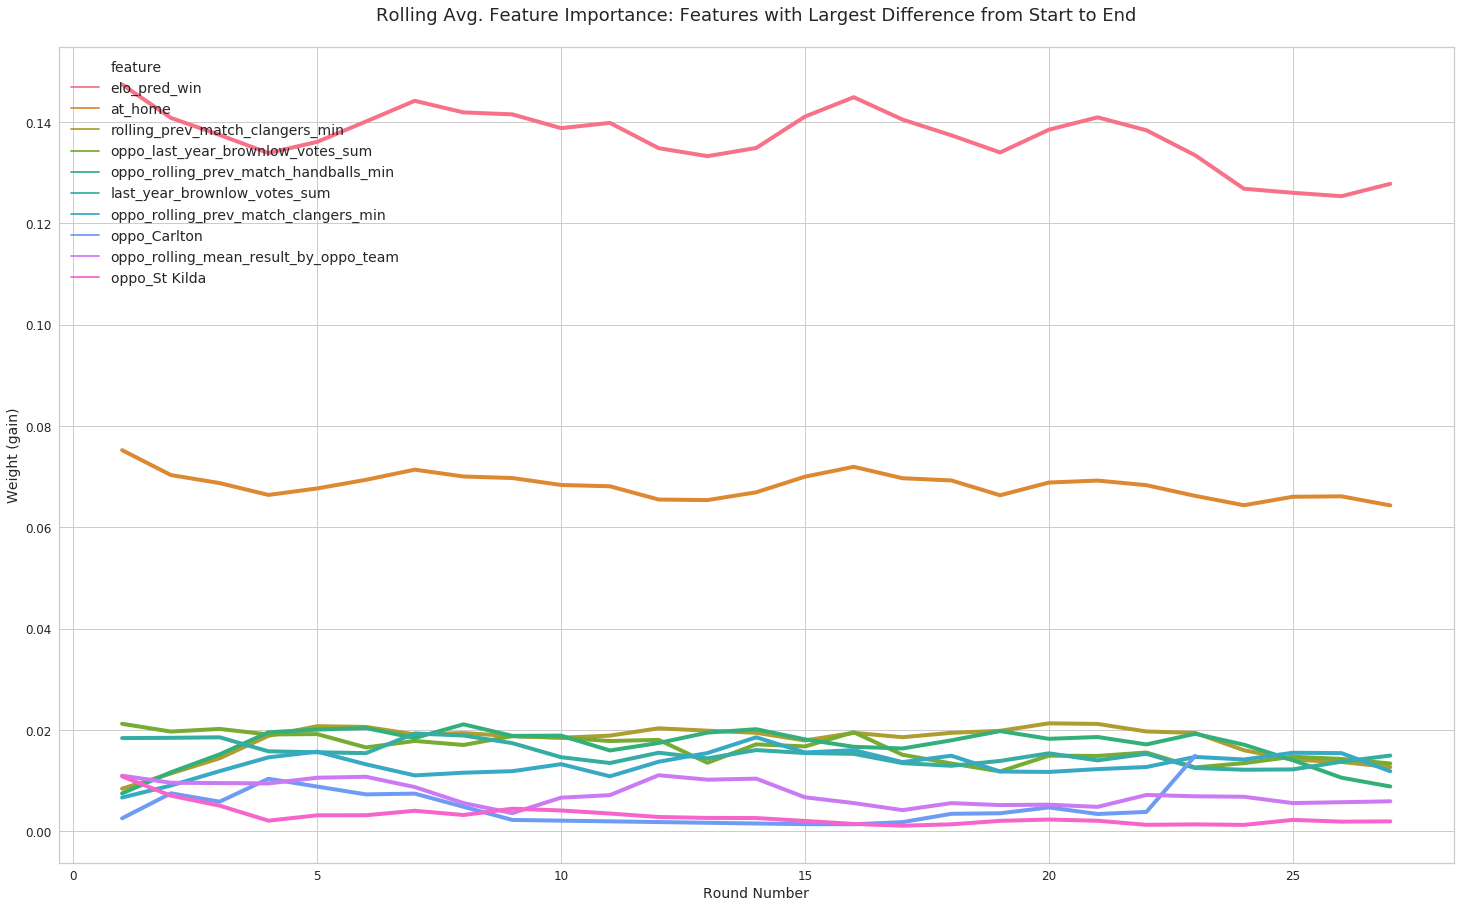

In [27]:
plot_df = (
    rolling_gains
    .loc[(gains_diff.head(10).index, slice(None)), :]
    .reset_index()
    .sort_values('weight', ascending=False)
)

plt.figure(figsize=(25, 15))

sbn.lineplot(
    x='round_number',
    y='weight',
    hue='feature',
    data=plot_df,
    lw=4,
    ci=None
)

plt.title(
    "Rolling Avg. Feature Importance: Features with Largest Difference from Start to End\n",
    fontsize=18
)
plt.ylabel("Weight (gain)", fontsize=14)
plt.xlabel("Round Number", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=14, loc='upper left')

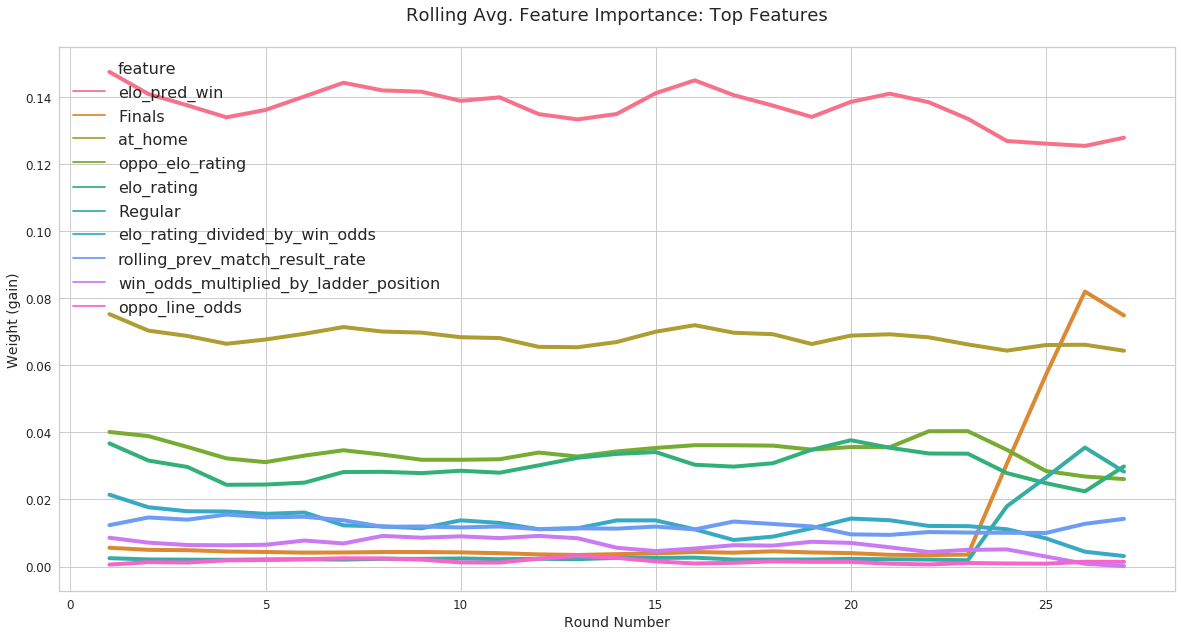

In [32]:
plot_df = (
    rolling_gains
    .loc[(avg_gains.head(10).index, slice(None)), :]
    .reset_index()
    .sort_values('weight', ascending=False)
)

plt.figure(figsize=(20, 10))

sbn.lineplot(
    x='round_number',
    y='weight',
    hue='feature',
    data=plot_df,
    lw=4,
    ci=None
)

plt.title("Rolling Avg. Feature Importance: Top Features\n", fontsize=18)
plt.ylabel("Weight (gain)", fontsize=14)
plt.xlabel("Round Number", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=16, loc='upper left')

### Feature importance across season is noisy

Even with a small rolling window, feature importance is pretty flat across the season, with some of the stronger features (`elo_pred_win`, `at_home`) losing importance as the season progreses, but only a little. The only interesting changes are for `Finals` and `Regular`, which become much more important during the finals rounds.

## V. Regression Visualizers

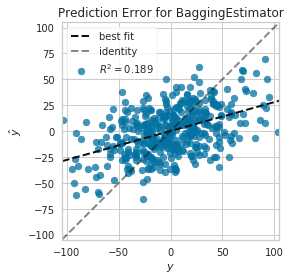

In [29]:
X_train, y_train = data.train_data()
X_test, y_test = data.test_data()

visualizer = regressor.PredictionError(tipresias)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()